<a href="https://colab.research.google.com/github/astrfo/AIQuest/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://github.com/astrfo/AutonomousOptimalExplorationThroughSatisficing/blob/main/AutonomousOptimalExplorationThroughSatisficing.ipynb




In [81]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [82]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])
        # print(f'prob: {self.prob}')

    def play(self, arm):
        if self.prob[arm] > np.random.rand():
            return 1
        else:
            return 0

In [83]:
class Policy(object):
    """
    各方策の実行
    """

    def __init__(self, policy, param):
        if 'RS-CH' == policy:
            self.act_policy = self.RS_CH
            self.aleph = param
        if 'RS-OPT' == policy:
            self.act_policy = self.RS_OPT
            self.aleph = param
        if 'e-greedy' == policy:
            self.act_policy = self.e_greedy
            self.epsilon = param
        if 'random' == policy:
            self.act_policy = self.random_
        if 'ThompsonSampling' == policy:
            self.act_policy = self.ThompsonSampling


    def RS_CH(self, V, RS, n):
        G = random.choice(np.where(V == V.max())[0])
        mu = np.exp(-n * self.D_KL(V, V[G]))
        aleph_list = V[G] * (1 - (V/V[G]) * mu) / (1 - mu)
        np.nan_to_num(aleph_list, copy=False)
        self.aleph = max(aleph_list)
        # print(f'aleph: {self.aleph}')
        return np.argmax(RS)

    def RS_OPT(self, _, RS, __):
        # print(f'aleph_opt: {self.aleph}')
        return np.argmax(RS)

    def e_greedy(self, V, _, __):
        if self.epsilon < np.random.rand():
            return np.random.choice(np.where(V == V.max())[0])
        else:
            return np.random.randint(len(V))

    def random_(self, V, _, __):
        return np.random.randint(len(V))

    # def ThompsonSampling(self, V, _, __):
    #     return 1

    def D_KL(self, p, q):
        return p*np.log(p/q) + (1-p)*np.log( (1-p) / (1-q) )

In [84]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    基準値alephの更新, KL情報量
    RS-greedy選択肢を試行する
    """

    def __init__(self, K, policy, param):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.policy = Policy(policy, param)

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0
        self.RS = np.zeros(self._K)

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self.RS = (self._n / self._N) * (self._V - self.policy.aleph)

    def select_arm(self):
        return self.policy.act_policy(self._V, self.RS, self._n)

In [85]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._algorithm = {"RS-CH": 1.0, "RS-OPT": 1.0}
        # self._algorithm = {"RS-CH": 1.0}
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._K = K
        self._regret = np.zeros(step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for algo, param in self._algorithm.items():
            self._agent = RSAgent(self._K, algo, param)
            print(f'algorithm: {algo}, param: {param}')
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                if algo == 'RS-OPT': self._agent.policy.aleph = sum(self._prob) / self._K
                self._agent.initialize()
                self._regretV = 0.0
                for s in range(self._step):
                    arm = self._agent.select_arm()
                    reward = self._env.play(arm)
                    self._agent.update(arm, reward)
                    self.calc_regret(t, s, arm)
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret, linestyle='dashed')
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._algorithm)

algorithm: RS-CH, param: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


algorithm: RS-OPT, param: 1.0


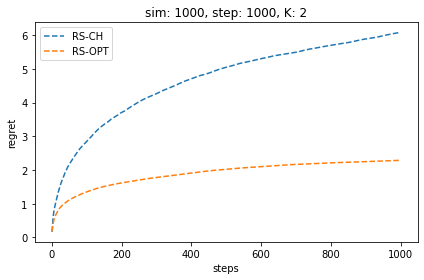

elapsed_time:145.1324872970581[sec]


In [86]:
def main():
    trial = 1000
    step = 1000
    K = 2
    sim = Simulator(trial, step, K)
    sim.run()




start = time.time()
main()
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")